In [30]:
import os
from pathlib import Path
import tarfile

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [31]:
data_dir = Path(".")
tar_path = data_dir / "WISDM_at_latest.tar.gz"
extract_dir = data_dir / "wisdm_extracted"

extract_dir.mkdir(exist_ok=True)

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print("Extracted to:", extract_dir.resolve())


C:\Users\syedw\AppData\Local\Temp\ipykernel_8728\3358553680.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Extracted to: C:\Users\syedw\WISDM_ML_Project\wisdm_extracted


In [32]:
for root, dirs, files in os.walk(extract_dir):
    for f in files:
        print(root, "->", f)


wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> readme.txt
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_demographics.txt
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_demographics_about.txt
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_raw.txt
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_raw_about.txt
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_transformed.arff
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_transformed_about.txt
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_unlabeled_raw.txt
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_unlabeled_raw_about.txt
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_unlabeled_transformed.arff
wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0 -> WISDM_at_v2.0_unlabele

In [33]:
from pathlib import Path

raw_file_path = Path("wisdm_extracted/home/share/data/public_sets/WISDM_at_v2.0/WISDM_at_v2.0_raw.txt")
print(raw_file_path, raw_file_path.exists())


wisdm_extracted\home\share\data\public_sets\WISDM_at_v2.0\WISDM_at_v2.0_raw.txt True


In [34]:
import pandas as pd

def load_wisdm_raw(path):
    """
    Parse WISDM raw file into a clean DataFrame.
    Expected format per line:
    user, activity, timestamp, x, y, z
    Some lines may end with ';' or be malformed -> we skip them.
    """
    rows = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Remove trailing semicolon if present
            if line.endswith(";"):
                line = line[:-1]
            parts = line.split(",")
            if len(parts) < 6:
                continue
            user = parts[0]
            activity = parts[1]
            timestamp = parts[2]
            try:
                x = float(parts[3])
                y = float(parts[4])
                z = float(parts[5])
            except ValueError:
                # skip malformed lines
                continue
            rows.append((user, activity, int(timestamp), x, y, z))

    df = pd.DataFrame(rows, columns=["user", "activity", "timestamp", "x", "y", "z"])
    return df

wisdm_df = load_wisdm_raw(raw_file_path)
print("Raw WISDM shape:", wisdm_df.shape)
wisdm_df.head()


Raw WISDM shape: (2980765, 6)


,user,activity,timestamp,x,y,z
0,1679,Walking,1370520469556,0.294132,-0.635605,-0.226936
1,1679,Walking,1370520469606,-0.499688,-0.604451,-0.226020
2,1679,Walking,1370520469656,-2.178345,0.713491,0.372017
3,1679,Walking,1370520469706,-2.797763,1.354899,-0.277638
4,1679,Walking,1370520469756,-2.167961,-1.327716,-0.554971


In [35]:
print("Raw WISDM shape:", wisdm_df.shape)
print(wisdm_df.head())
print(wisdm_df['activity'].value_counts())


Raw WISDM shape: (2980765, 6)
   user activity      timestamp         x         y         z
0  1679  Walking  1370520469556  0.294132 -0.635605 -0.226936
1  1679  Walking  1370520469606 -0.499688 -0.604451 -0.226020
2  1679  Walking  1370520469656 -2.178345  0.713491  0.372017
3  1679  Walking  1370520469706 -2.797763  1.354899 -0.277638
4  1679  Walking  1370520469756 -2.167961 -1.327716 -0.554971
activity
Walking      1255923
Sitting       663706
Jogging       438871
Standing      288873
LyingDown     275967
Stairs         57425
Name: count, dtype: int64


In [36]:
#DAtaset overview EDA
print("Dataset shape:", wisdm_df.shape)
wisdm_df.head()


Dataset shape: (2980765, 6)


,user,activity,timestamp,x,y,z
0,1679,Walking,1370520469556,0.294132,-0.635605,-0.226936
1,1679,Walking,1370520469606,-0.499688,-0.604451,-0.226020
2,1679,Walking,1370520469656,-2.178345,0.713491,0.372017
3,1679,Walking,1370520469706,-2.797763,1.354899,-0.277638
4,1679,Walking,1370520469756,-2.167961,-1.327716,-0.554971


In [37]:
#Null values check
wisdm_df.isna().sum()


user         0
activity     0
timestamp    0
x            0
y            0
z            0
dtype: int64

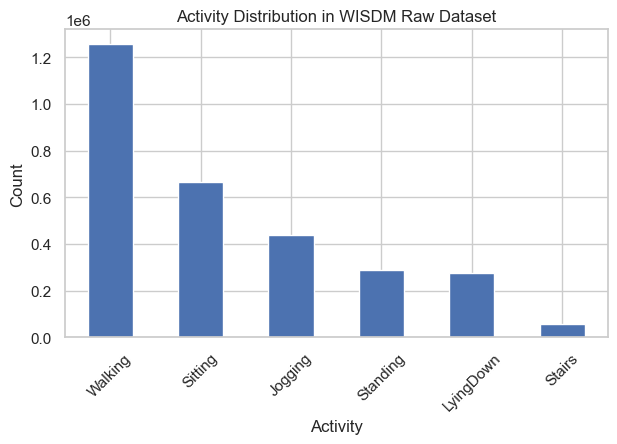

activity
Walking      1255923
Sitting       663706
Jogging       438871
Standing      288873
LyingDown     275967
Stairs         57425
Name: count, dtype: int64

In [38]:
#Activity distribution
import matplotlib.pyplot as plt

activity_counts = wisdm_df['activity'].value_counts()

plt.figure(figsize=(7,4))
activity_counts.plot(kind='bar')
plt.title("Activity Distribution in WISDM Raw Dataset")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

activity_counts


In [39]:
#Descriptive Statistic
wisdm_df[['x','y','z']].describe()


,x,y,z
count,2.980765e+06,2.980765e+06,2.980765e+06
mean,4.844853e+10,-1.373680e+05,1.984417e+14
std,8.364586e+13,2.371697e+08,3.426074e+17
min,-4.628739e+01,-4.094710e+11,-4.820949e+01
25%,-2.230362e+00,-2.700000e-01,-1.225831e+00
50%,-2.130529e-03,1.650000e+00,1.160644e-02
75%,2.508824e+00,8.850000e+00,2.476410e+00
max,1.444137e+17,8.013994e+01,5.915081e+20


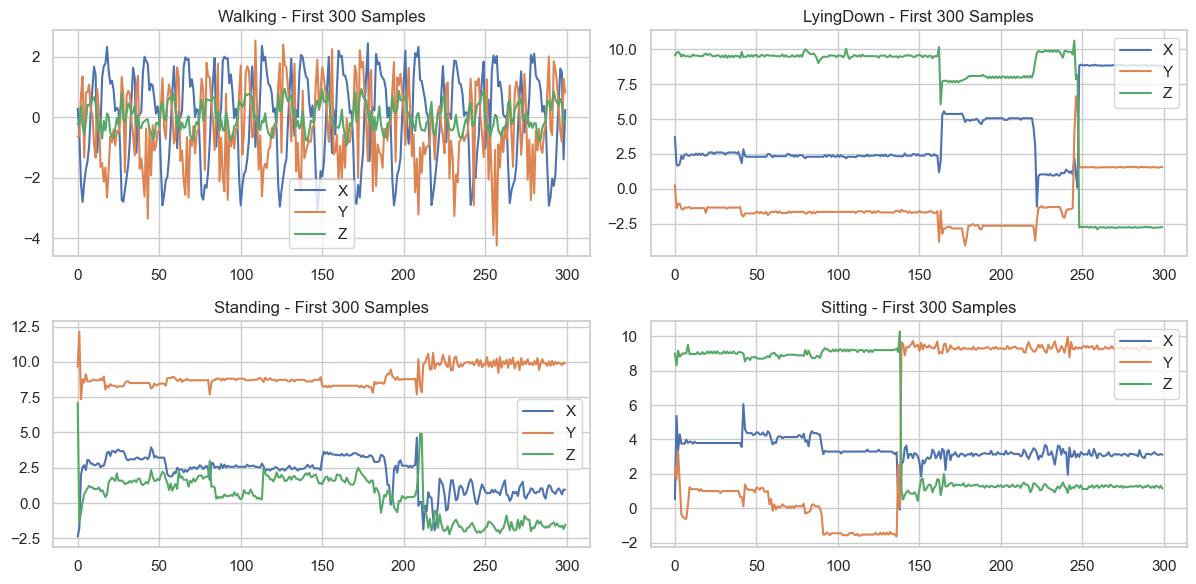

In [40]:
#sample signals for each activity
import numpy as np

plt.figure(figsize=(12,6))

activities = wisdm_df['activity'].unique()[:4]  # plot first 4 to keep it clean

for i, act in enumerate(activities):
    sample = wisdm_df[wisdm_df['activity'] == act].iloc[:300]  # first 300 points
    plt.subplot(2,2,i+1)
    plt.plot(sample['x'].values, label='X')
    plt.plot(sample['y'].values, label='Y')
    plt.plot(sample['z'].values, label='Z')
    plt.title(f"{act} - First 300 Samples")
    plt.legend()

plt.tight_layout()
plt.show()


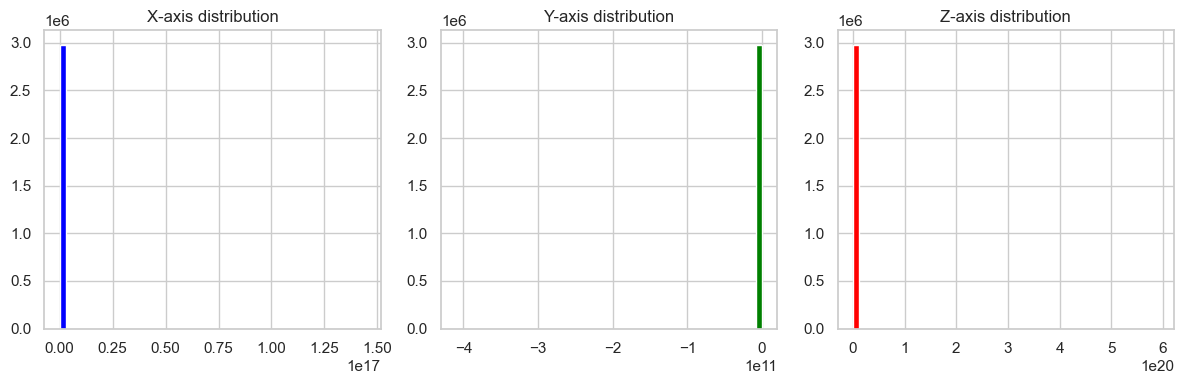

In [41]:
#Histogram and aceelometer values
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(wisdm_df['x'], bins=50, color='blue')
plt.title("X-axis distribution")

plt.subplot(1,3,2)
plt.hist(wisdm_df['y'], bins=50, color='green')
plt.title("Y-axis distribution")

plt.subplot(1,3,3)
plt.hist(wisdm_df['z'], bins=50, color='red')
plt.title("Z-axis distribution")

plt.tight_layout()
plt.show()


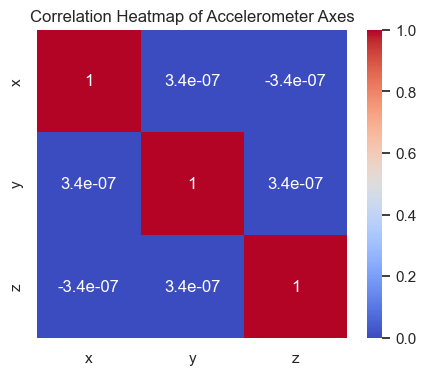

In [42]:
#Correlation heatmap
import seaborn as sns

corr = wisdm_df[['x','y','z']].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Accelerometer Axes")
plt.show()


In [43]:
#Feature Extraction

In [44]:
import numpy as np

WINDOW_SIZE = 128
STEP = 64   # 50% overlap

windows = []
labels = []

# Group by each activity
for activity in wisdm_df["activity"].unique():
    act_df = wisdm_df[wisdm_df["activity"] == activity]

    x_vals = act_df["x"].values
    y_vals = act_df["y"].values
    z_vals = act_df["z"].values

    n = len(act_df)
    for start in range(0, n - WINDOW_SIZE, STEP):
        end = start + WINDOW_SIZE

        x_win = x_vals[start:end]
        y_win = y_vals[start:end]
        z_win = z_vals[start:end]

        window = np.vstack([x_win, y_win, z_win]).T  # Shape: (128, 3)
        windows.append(window)
        labels.append(activity)

print("Total windows:", len(windows))


Total windows: 46565


In [45]:
def extract_features(window):
    x = window[:, 0]
    y = window[:, 1]
    z = window[:, 2]

    feats = []

    # mean, std, min, max for x,y,z
    for axis in [x, y, z]:
        feats.append(axis.mean())
        feats.append(axis.std())
        feats.append(axis.min())
        feats.append(axis.max())

    # magnitude features
    mag = np.sqrt(x*x + y*y + z*z)
    feats.append(mag.mean())
    feats.append(mag.std())

    return np.array(feats)

X = np.array([extract_features(w) for w in windows])
y = np.array(labels)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (46565, 14)
Labels shape: (46565,)


In [46]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_
print("Classes:", class_names)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, 
    test_size=0.2, 
    stratify=y_enc, 
    random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Classes: ['Jogging' 'LyingDown' 'Sitting' 'Stairs' 'Standing' 'Walking']


In [47]:
from sklearn.metrics import accuracy_score, classification_report

models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "LDA": LinearDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM_RBF": SVC(kernel='rbf'),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print("Accuracy:", acc)
    print(classification_report(y_test, preds, target_names=class_names))
    results[name] = acc



===== LogReg =====
Accuracy: 0.5648018898314184
              precision    recall  f1-score   support

     Jogging       0.46      0.02      0.04      1371
   LyingDown       0.00      0.00      0.00       862
     Sitting       0.50      0.85      0.63      2074
      Stairs       0.00      0.00      0.00       179
    Standing       0.00      0.00      0.00       903
     Walking       0.60      0.88      0.72      3924

    accuracy                           0.56      9313
   macro avg       0.26      0.29      0.23      9313
weighted avg       0.43      0.56      0.45      9313


===== LDA =====
Accuracy: 0.5861698700740899
              precision    recall  f1-score   support

     Jogging       0.73      0.25      0.37      1371
   LyingDown       0.00      0.00      0.00       862
     Sitting       0.47      0.91      0.62      2074
      Stairs       0.00      0.00      0.00       179
    Standing       0.00      0.00      0.00       903
     Walking       0.66      0.82    

C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\syedw\anaconda3\Lib\site-packag

Accuracy: 0.8663159025018791
              precision    recall  f1-score   support

     Jogging       0.81      0.78      0.80      1371
   LyingDown       0.93      0.89      0.91       862
     Sitting       0.88      0.91      0.89      2074
      Stairs       0.59      0.31      0.40       179
    Standing       0.84      0.79      0.81       903
     Walking       0.88      0.91      0.89      3924

    accuracy                           0.87      9313
   macro avg       0.82      0.77      0.78      9313
weighted avg       0.86      0.87      0.86      9313


===== SVM_RBF =====
Accuracy: 0.6808761945667346
              precision    recall  f1-score   support

     Jogging       0.78      0.44      0.56      1371
   LyingDown       0.00      0.00      0.00       862
     Sitting       0.55      0.87      0.68      2074
      Stairs       0.00      0.00      0.00       179
    Standing       0.70      0.66      0.68       903
     Walking       0.75      0.85      0.80      3924

C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8414044883496188
              precision    recall  f1-score   support

     Jogging       0.95      0.70      0.81      1371
   LyingDown       0.96      0.69      0.81       862
     Sitting       0.80      0.89      0.84      2074
      Stairs       0.00      0.00      0.00       179
    Standing       0.92      0.71      0.81       903
     Walking       0.81      0.96      0.88      3924

    accuracy                           0.84      9313
   macro avg       0.74      0.66      0.69      9313
weighted avg       0.84      0.84      0.83      9313



C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\syedw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Improving Accuracy By Upgrading Time domain features and Frequency domain Features


In [49]:
!pip install scipy


In [50]:
import numpy as np
from scipy.stats import iqr
from scipy.fft import rfft, rfftfreq

def extract_features(window, sampling_rate=20):  # WISDM ≈ 20Hz
    x = window[:, 0]
    y = window[:, 1]
    z = window[:, 2]

    feats = []

    def axis_features(axis):
        f = []
        # basic stats
        f.append(axis.mean())
        f.append(axis.std())
        f.append(axis.min())
        f.append(axis.max())
        f.append(np.median(axis))
        # IQR
        f.append(iqr(axis))
        # energy
        f.append(np.sum(axis**2) / len(axis))
        # zero crossings
        f.append(np.sum(np.diff(np.sign(axis)) != 0))
        return f

    # time-domain per axis
    for axis in [x, y, z]:
        feats.extend(axis_features(axis))

    # magnitude features
    mag = np.sqrt(x*x + y*y + z*z)
    feats.append(mag.mean())
    feats.append(mag.std())
    feats.append(iqr(mag))
    feats.append(np.sum(mag**2) / len(mag))
    feats.append(np.sum(np.diff(np.sign(mag)) != 0))

    # simple frequency-domain on magnitude
    fft_vals = rfft(mag)
    fft_freqs = rfftfreq(len(mag), d=1/sampling_rate)
    fft_power = np.abs(fft_vals)

    # dominant frequency
    dom_idx = np.argmax(fft_power)
    dom_freq = fft_freqs[dom_idx]
    feats.append(dom_freq)

    # frequency-band energy
    feats.append(np.sum(fft_power**2))

    # convert to array and clean
    feats = np.array(feats, dtype=float)
    feats = np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)
    return feats


In [51]:
X = np.array([extract_features(w) for w in windows])
y = np.array(labels)

print("New feature vector length:", X.shape[1])
print("Feature matrix shape:", X.shape)


New feature vector length: 31
Feature matrix shape: (46565, 31)


In [52]:
import numpy as np

print("NaN count in X:", np.isnan(X).sum())
print("Inf count in X:", np.isinf(X).sum())


NaN count in X: 0
Inf count in X: 0


In [53]:
X = np.array([extract_features(w) for w in windows])
y = np.array(labels)

print("Feature matrix shape:", X.shape)



Feature matrix shape: (46565, 31)


In [54]:
import numpy as np

X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print("NaN count after cleaning:", np.isnan(X).sum())
print("Inf count after cleaning:", np.isinf(X).sum())


NaN count after cleaning: 0
Inf count after cleaning: 0


In [55]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    stratify=y_enc,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
    "LogReg": LogisticRegression(max_iter=5000),
    "LDA": LinearDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM_RBF": SVC(kernel='rbf', C=10, gamma='scale'),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print("Accuracy:", acc)
    print(classification_report(y_test, preds, target_names=class_names))
    results[name] = acc



===== LogReg =====
Accuracy: 0.6994523783957908
              precision    recall  f1-score   support

     Jogging       0.83      0.67      0.74      1371
   LyingDown       0.34      0.18      0.24       862
     Sitting       0.51      0.79      0.62      2074
      Stairs       0.00      0.00      0.00       179
    Standing       0.60      0.48      0.54       903
     Walking       0.88      0.86      0.87      3924

    accuracy                           0.70      9313
   macro avg       0.53      0.50      0.50      9313
weighted avg       0.70      0.70      0.69      9313


===== LDA =====
Accuracy: 0.6909696123698057
              precision    recall  f1-score   support

     Jogging       0.85      0.70      0.77      1371
   LyingDown       0.33      0.21      0.26       862
     Sitting       0.49      0.76      0.60      2074
      Stairs       0.06      0.01      0.02       179
    Standing       0.53      0.46      0.49       903
     Walking       0.91      0.84    

In [57]:
print("\nModel Accuracy Summary:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")



Model Accuracy Summary:
LogReg: 0.6995
LDA: 0.6910
KNN: 0.9382
SVM_RBF: 0.8545
RandomForest: 0.9692


# confusion matrix for random forest

Confusion matrix shape: (6, 6)


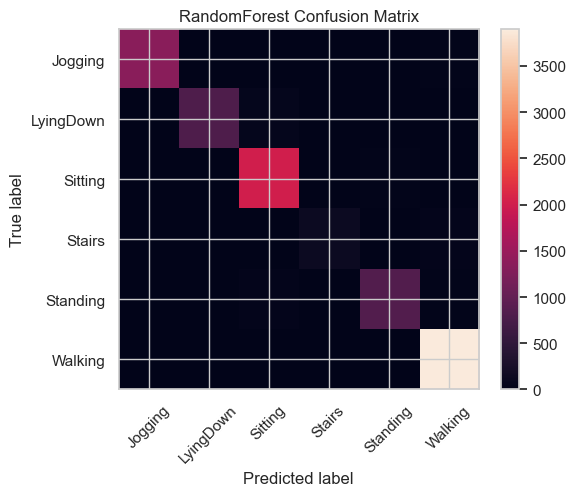

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get RF predictions on test set
rf_model = models["RandomForest"]
y_pred_rf = rf_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion matrix shape:", cm.shape)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


# model accuracy comparision

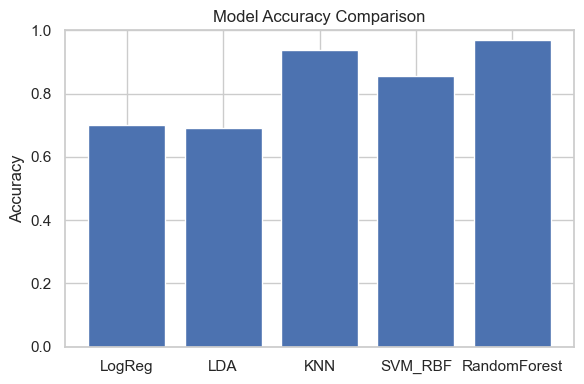

In [61]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
accuracies = [results[m] for m in model_names]

plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies)
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()


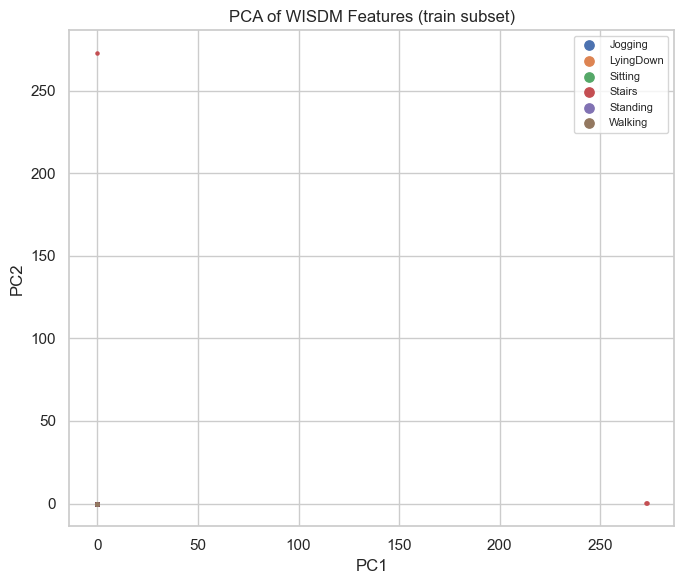

Explained variance by PC1+PC2: 0.7436409366626864


In [62]:
from sklearn.decomposition import PCA

# Take a subset for plotting to avoid heavy rendering
n_samples_plot = 5000
if X_train_scaled.shape[0] > n_samples_plot:
    rng = np.random.RandomState(42)
    indices = rng.choice(X_train_scaled.shape[0], size=n_samples_plot, replace=False)
    X_plot = X_train_scaled[indices]
    y_plot = y_train[indices]
else:
    X_plot = X_train_scaled
    y_plot = y_train

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_plot)

plt.figure(figsize=(7, 6))
for idx, cls in enumerate(class_names):
    mask = (y_plot == idx)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=5, label=cls)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of WISDM Features (train subset)")
plt.legend(markerscale=3, fontsize=8)
plt.tight_layout()
plt.show()

print("Explained variance by PC1+PC2:",
      pca.explained_variance_ratio_.sum())


In [63]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fix subset selection
n_samples_plot = 5000
rng = np.random.RandomState(42)

if X_train_scaled.shape[0] > n_samples_plot:
    idx = rng.choice(X_train_scaled.shape[0], size=n_samples_plot, replace=False)
else:
    idx = np.arange(X_train_scaled.shape[0])

X_plot = X_train_scaled[idx]
y_plot = y_train[idx]

print("Subset shape:", X_plot.shape)


Subset shape: (5000, 31)


In [64]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_plot)

print("PCA transformed shape:", X_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_.sum())


PCA transformed shape: (5000, 2)
Explained variance: 0.7436409366626864


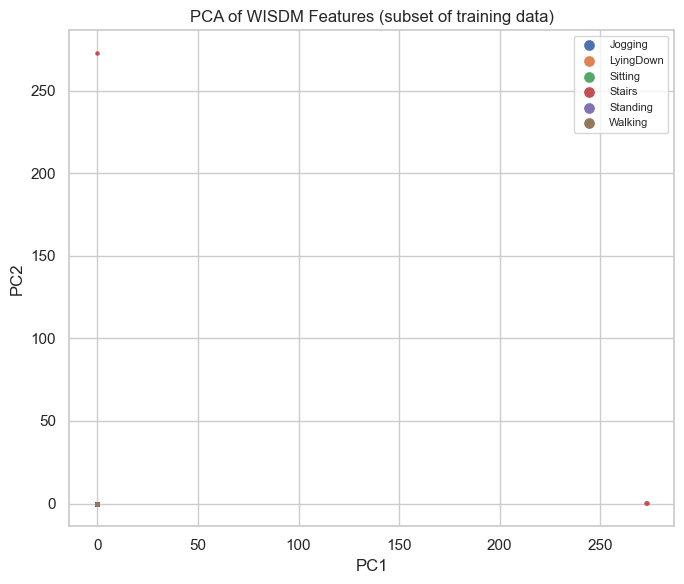

In [65]:
plt.figure(figsize=(7, 6))

for cls in np.unique(y_plot):
    mask = (y_plot == cls)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=5, label=class_names[cls])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of WISDM Features (subset of training data)")
plt.legend(markerscale=3, fontsize=8)
plt.tight_layout()
plt.show()


In [66]:
print("PC1 min/max:", X_pca[:,0].min(), X_pca[:,0].max())
print("PC2 min/max:", X_pca[:,1].min(), X_pca[:,1].max())


PC1 min/max: -0.23962110407371165 272.86932712703486
PC2 min/max: -0.10636762010248992 272.9127434216487


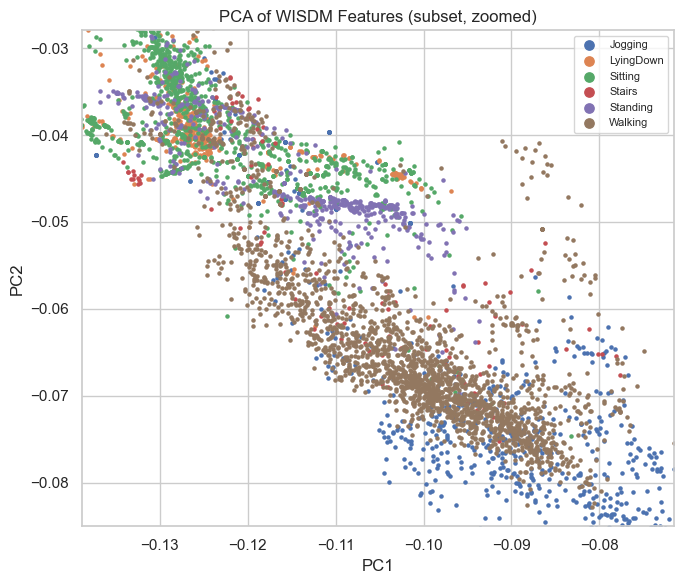

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Compute percentile-based axis limits to ignore extreme outliers
x_min, x_max = np.percentile(X_pca[:,0], [1, 99])
y_min, y_max = np.percentile(X_pca[:,1], [1, 99])

plt.figure(figsize=(7, 6))

for cls in np.unique(y_plot):
    mask = (y_plot == cls)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=5, label=class_names[cls])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of WISDM Features (subset, zoomed)")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(markerscale=3, fontsize=8)
plt.tight_layout()
plt.show()


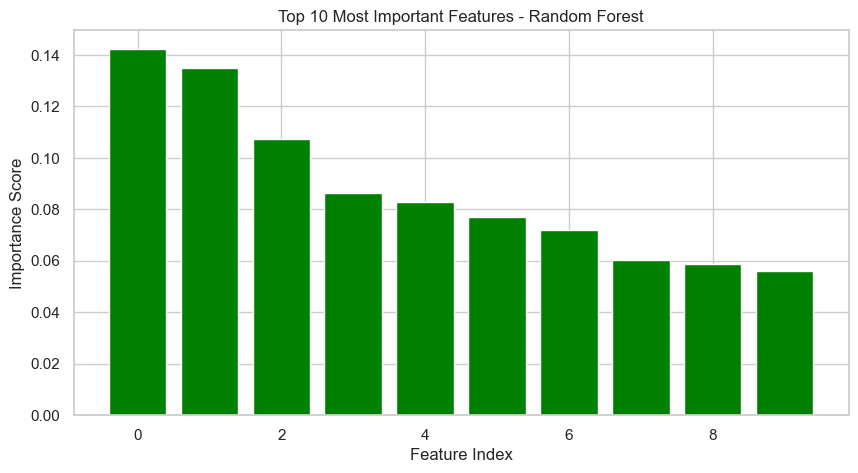

In [106]:
#feature importance Random forest
rf_model = models["RandomForest"]
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(10), importances[indices[:10]], color='green')
plt.title("Top 10 Most Important Features - Random Forest")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()


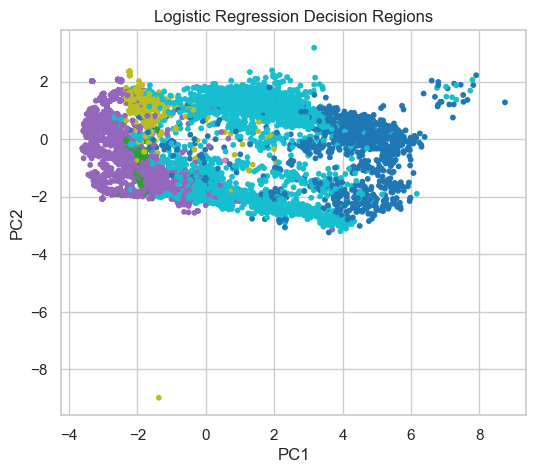

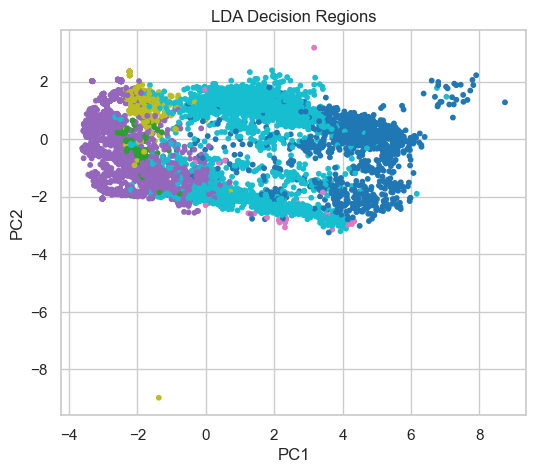

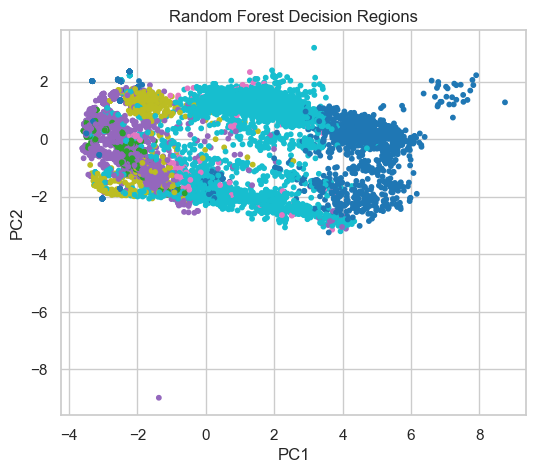

In [108]:
#PCA and Decision Region
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

x1, x2 = X_pca[:, 0], X_pca[:, 1]

def plot_decision(model, title):
    preds = model.predict(X_test_scaled)
    plt.figure(figsize=(6,5))
    plt.scatter(x1, x2, c=preds, cmap='tab10', s=10)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_decision(models["LogReg"], "Logistic Regression Decision Regions")
plot_decision(models["LDA"], "LDA Decision Regions")
plot_decision(models["RandomForest"], "Random Forest Decision Regions")


In [68]:
import joblib

joblib.dump(models["RandomForest"], "wisdm_rf_model.joblib")
joblib.dump(scaler, "wisdm_scaler.joblib")
joblib.dump(le, "wisdm_label_encoder.joblib")

print("Saved successfully!")


Saved successfully!
